<a href="https://colab.research.google.com/github/dssp-ethz/DSSP-Illustrations/blob/main/LMS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LMS Algorithm
We wish to estimate $X$ from some signal $Y$ using a (causal) Wiener filter, i.e.
$$\hat{X}[k] = \sum\limits_{n=0}^N h_k [n] Y [k-n]$$

We calibrate the filter in the adaptive mode, where we actually know $X$. We use the update formula:

$$\begin{pmatrix} h_{k+1}[0]\\h_{k+1}[1]\\ \vdots\\h_{k+1}[N] \end{pmatrix} = \begin{pmatrix} h_{k}[0]\\h_{k}[1]\\ \vdots\\h_{k}[N] \end{pmatrix} + \beta \left( X[k] - \hat{X}[k] \right) \begin{pmatrix} Y[k-0]\\Y[k-1]\\ \vdots\\Y[k-N] \end{pmatrix}$$

where $\beta$ is an adjustable learning parameter.

In [13]:
# input are ndarrays: (w)eights, (e)rror, y, x
# output is nothing, however arguments are changed
def LMS(w, e, y, x):
  assert len(x) == len(y)
  assert len(e) == len(y)-len(w)

  for l in range (0, e):
    yl = y[l + len(w) : l : -1] #most recent values for y
    el = x[l + len(w)] - np.dot(yl, w) #x[l+len(w)] - \hat{x}[l+len(w)]

    w = w + beta * el * yl
    e[l] = el

In [5]:
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
%matplotlib inline
#-------------------------------------------------------------------------------

betaG = 0.05
NG = 15 #Filter size

logPlotG = False

def update_parameters(N, beta, logPlot):
  global NG, betaG, logPlotG
  NG,  betaG, logPlotG = N, beta, logPlot

widgets.interact(update_parameters,
  N = widgets.IntSlider(
    value=15,
    min=1,
    max=30,
    description='N'),
  beta = widgets.FloatSlider(
    value=0.05,
    min=0,
    max=1,
    description='beta'),
  logPlot = widgets.Checkbox(
    value=False,
    description='logarithmic plot')
);


interactive(children=(IntSlider(value=15, description='N', max=30, min=1), FloatSlider(value=0.05, description…

In [ ]:
#example signals and , use LMS, plot adjustable parameter

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning 

<StemContainer object of 3 artists>

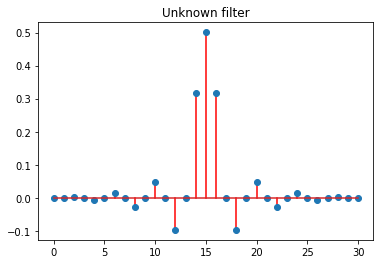

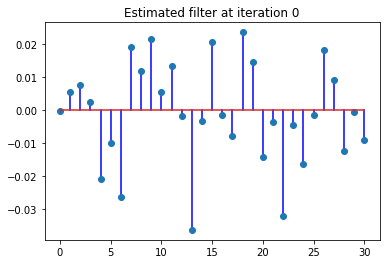

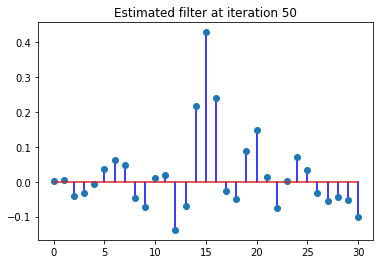

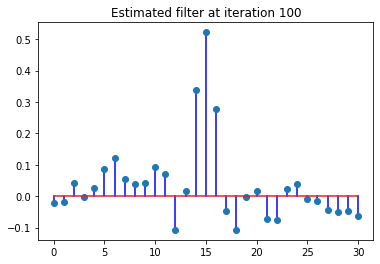

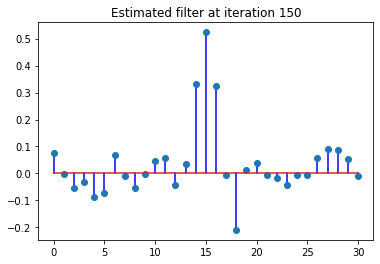

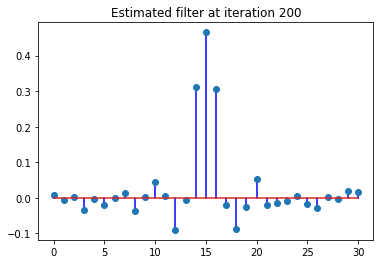

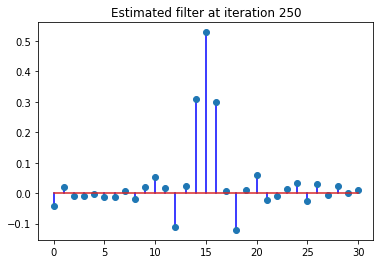

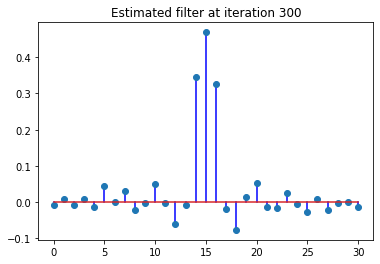

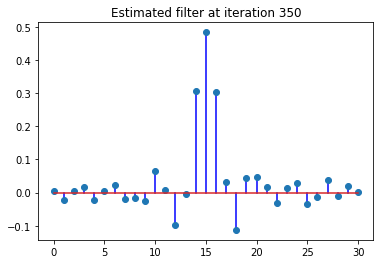

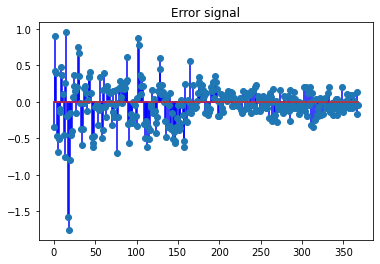

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
%matplotlib inline
N = 400
K = 31
# Input size
# Filter size
3
x = np.random.randn(N)
h = signal.firwin(K, 0.5)
t = signal.convolve(x, h)
t = t + 0.01 * np.random.randn(len(t)) # with added noise
mu = 0.05
fig = plt.figure()
plt.title('Unknown filter')
plt.stem(h, linefmt = 'r')
w= np.zeros(K)
e = np.zeros(N-K)
for n in range(0, N-K):
    xn = x[n+K:n:-1]
    en = t[n+K] - np.dot(xn , w)
    w = w + mu * en * xn
    e[n] = en
    # LMS step size
    # Initial filter
    # Error
    # Update filter (LMS algorithm)
    # Record error
    # Input to the filter
    # FIR system to be identified
    # Target output signal
    # Plot updated filter after each iteration
    if (n % 50 == 0):
        plt.figure()
        plt.title('Estimated filter at iteration %d' % n)
        plt.stem(w, linefmt = 'b')
plt.figure()
plt.title('Error signal')
plt.stem(e, linefmt = 'b')